In [27]:

import os
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

import pathlib
import pickle
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import matplotlib.pyplot as plt

from module.lino_module.preprocess import mode_of_freq, src_tgt_split, auxiliary_model_loader
from module.lino_module.model import TransformerModel, WithAuxiliary
from module.lino_module.inference import RecurrentInference
from module.lino_module.ploter import inference_ploter

## データの呼び出し

In [28]:
saving = False

dir_path = './models_ax/'  # Auxiliary Model
kwrgs, model, file_name = auxiliary_model_loader(dir_path, TransformerModel, TransformerModel)

ds = kwrgs['data']
step_num = kwrgs['step_num']

Index: 0
kw_inf

Index: 1
seq(10)d_model(16)dilation(3)src_tgt_seq((9, 9))step_num(5)daily(True)weekday(True)weekly(False)monthly(True)scaler(StandardScaler).pht

selected model :
seq(10)d_model(16)dilation(3)src_tgt_seq((9, 9))step_num(5)daily(True)weekday(True)weekly(False)monthly(True)scaler(StandardScaler)


# 再帰的推論

## ４半期ごとの予測(2014,01〜)

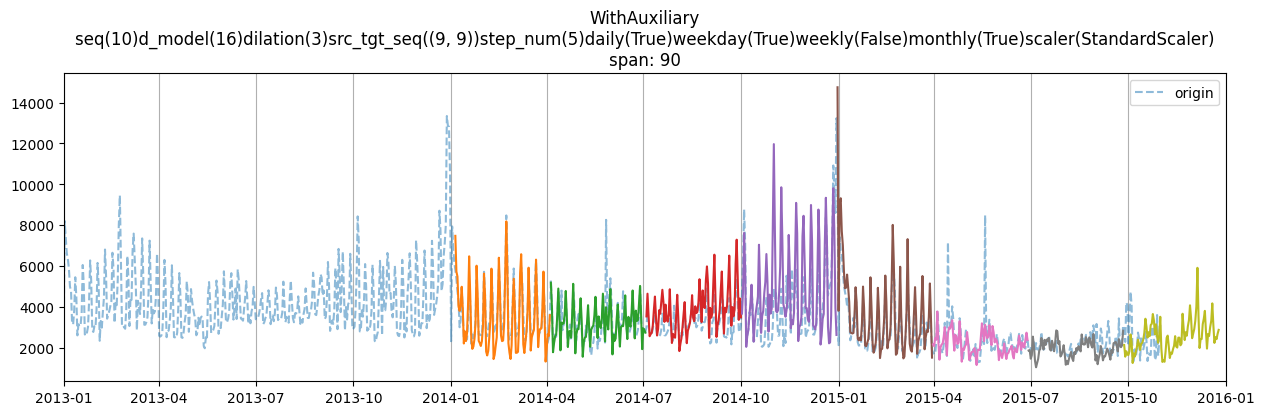

In [29]:
import matplotlib.dates as mdates

# 予測日数の設定
span = 90  # データの更新頻度日数
prediction_days = 365 + 10 * 30  # 推論日数 月数 日数
freq = int(prediction_days / step_num)  # 推論回数

# 保存先
img_path = './imgs/img_quarter/'
img_name = f'{model._get_name()}' + file_name + f'span_{span}'

# 描画と保存
plt.figure(figsize=(15, 4))
plt.plot(ds, label='origin', alpha=0.5, linestyle='dashed')

# 推論
cached = prediction_days
for _ in range(prediction_days//span + 1):
    data = ds[:-cached]  # 推論開始データ
    cached -= span
    self2 = RecurrentInference(model, **kwrgs)
    self2(data)
    from_freq = self2.predict(span//step_num)
    plt.plot(from_freq)

xmin = datetime.datetime.strptime('2013-01', '%Y-%m')
xmax = datetime.datetime.strptime('2016-01', '%Y-%m')
plt.xlim([xmin,xmax])

locator = mdates.MonthLocator(bymonthday=1, interval=3)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.grid(axis='x')
plt.legend()
plt.title(f'{model._get_name()}\n'+ file_name + f'\nspan: {span}')
if saving:
    plt.savefig(img_path + img_name)
plt.show()

## 最新データから指定日後の予測推移

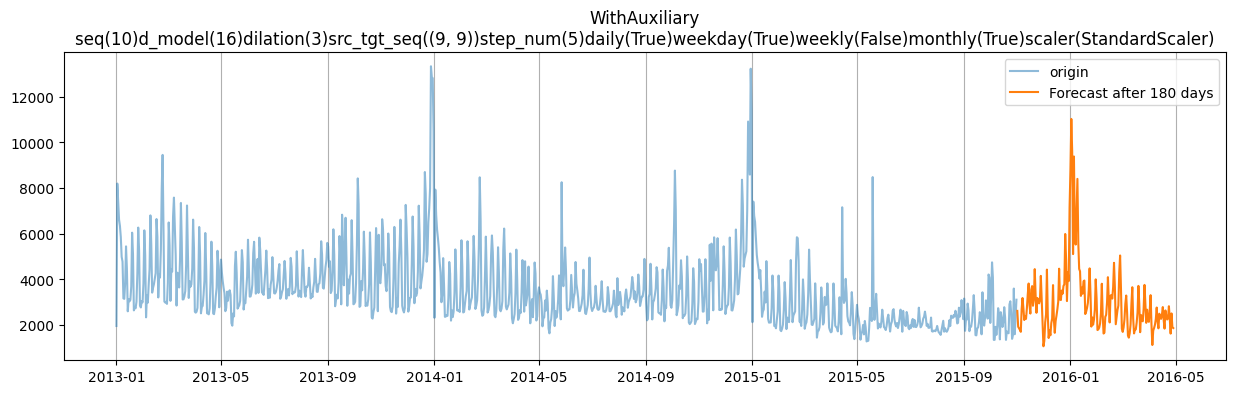

In [30]:
# 予測日数を設定
prediction_days = 180  # 推論日数
freq = int(prediction_days / step_num)  # 推論回数

# 保存先
img_path = './imgs/img_inference/'
img_name = f'{model._get_name()}' + file_name

# 推論
self = RecurrentInference(model, **kwrgs)
self(ds)
plot_kw = {'ori': ds,
           'pred': self.predict(freq),
           'label': f'Forecast after {freq * step_num} days',
           'title': f'{model._get_name()}\n'+ file_name,
           'figsize': (15, 4),
           'saving': saving,
           'path': img_path + img_name}

# 描画と保存
inference_ploter(**plot_kw)

## 指定日前から最新データ日までの予測推移

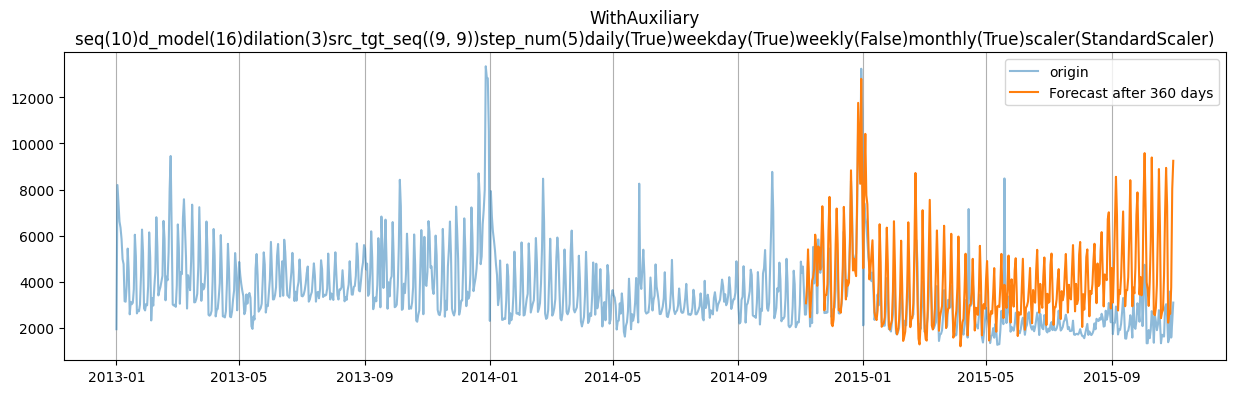

In [31]:
# 予測日数の設定
prediction_days = 360  # 推論日数
freq = int(prediction_days / step_num)  # 推論回数
data = ds[:-prediction_days]  # 推論開始データ

# 推論
self = RecurrentInference(model, **kwrgs)
self(data)
plot_kw = {'ori': ds,
           'pred': self.predict(freq),
           'label': f'Forecast after {freq * step_num} days',
           'title': f'{model._get_name()}\n'+ file_name,
           'figsize': (15, 4),
           'saving': False,
           'path': None,}
# 描画と保存
inference_ploter(**plot_kw)